In [1]:
!pip install --upgrade biopython

In [2]:
from Bio import Entrez
import spacy, re, pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import networkx as nx, matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
import spacy

In [3]:
nlp = spacy.load(r"C:\Users\sayye\Downloads\en_ner_bionlp13cg_md-0.4.0\en_ner_bionlp13cg_md-0.4.0\en_ner_bionlp13cg_md\en_ner_bionlp13cg_md-0.4.0")

C:\Users\sayye\anaconda3\Lib\site-packages\spacy\util.py:922: UserWarning: [W095] Model 'en_ner_bionlp13cg_md' (0.4.0) was trained with spaCy v3.0.1 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sayye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sayye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
Entrez.email = 'sayyedsaniya1010@gmail.com'
Entrez.api_key = None #optional

#skipped reinstallation

In [6]:
def fetch_pubmed_abstracts(query, max_records=10):
    '''Searches Pubmed for a given query, retrieves the pubmed IDs of
    a few matching papers, Fetch thier abstracts and titles,
    Returns:
    in a list of dictionaries'''
    h = Entrez.esearch(db='pubmed', term=query, retmax=max_records)
    ids = Entrez.read(h)['IdList']; h.close()
    if not ids:
        return []
    h = Entrez.efetch(db='pubmed', id=','.join(ids), retmode='xml'); recs = Entrez.read(h)
    h.close()
    out = []
    for art in recs.get('PubmedArticle', []):
        pmid = str(art['MedlineCitation']['PMID'])
        article = art['MedlineCitation']['Article']
        title = article.get('ArticleTitle','')
        abstract = ''
        if article.get('Abstract'):
            parts = article['Abstract'].get('AbstractText')
            if isinstance(parts, list):
                texts = []
                for p in parts:
                    if isinstance(p, str):
                        texts.append(p)
                    elif isinstance(p, dict):
                        texts.append(p.get('_',''))
                abstract = ' '.join(texts)
            elif isinstance(parts, dict):
                abstract = parts
            elif isinstance(parts, dict):
                abstract = parts.get(' ', '')
        out.append({'pmid': pmid, 'title': str(title), 'abstract': abstract})
    return out

In [7]:
docs = fetch_pubmed_abstracts('cancer drug', max_records=10)
for d in docs:
    print(d['pmid'], '-', d['title'][:120])

41111411 - Pan-Cancer Analyses of Shared and Distinct Gene Expression in 17 Cancers: Rethinking Cancer Classification and Moving Be
41111393 - The Proteostasis Network is a Therapeutic Target in Acute Myeloid Leukemia.
41111358 - BCL-2 inhibition in Waldenström macroglobulinaemia and marginal zone lymphoma.
41111237 - Glutathione-Responsive Polyhomocysteine Derivatives with Ultralow Toxicity toward Therapeutic Delivery.
41111131 - Integrated computational-experimental pipeline for CHK1 inhibitor discovery: structure-based identification of novel che
41111109 - Assessing SMC Complex Function in Replication Fork Progression with DNA Fiber Assays.
41111090 - YAP/TEAD inhibitor VT3989 in solid tumors: a phase 1/2 trial.
41111074 - Comprehensive evaluation of high dose methotrexate therapy: a retrospective observational trial.
41111053 - Nuclear receptor ESRRA promotes ERα-positive breast cancer through dual action on super enhancers and promoters to regul
41111032 - ESMO guidance on the us

In [8]:
def clean_text(txt):
    t = re.sub(r'\s+,',' ', txt or '').strip()
    t = re.sub(r'\[[0-9]+\]', '', t)
    return t

def remove_stopwords(txt):
    tokens = [w for w in word_tokenize(txt) if re.match(r'\w', w)]
    return ' '.join([w for w in tokens if w.lower() not in stop])

#nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

print(extract_entities(clean_text(docs[0]['abstract'])))

[('Cancer', 'CANCER'), ('pan-cancer', 'CANCER'), ('cancers', 'CANCER'), ('pan-cancer', 'CANCER'), ('cancers', 'CANCER'), ('adrenocortical cancer', 'CANCER'), ('lung cancer', 'CANCER'), ('kidney cancer', 'CANCER'), ('colorectal cancer', 'CANCER'), ('tissue', 'TISSUE'), ('TFs', 'CELL'), ('miR-124-3p', 'GENE_OR_GENE_PRODUCT'), ('miR-7106-5p', 'GENE_OR_GENE_PRODUCT'), ('SP1', 'GENE_OR_GENE_PRODUCT'), ('RELA', 'GENE_OR_GENE_PRODUCT'), ('NF-κB Subunit', 'GENE_OR_GENE_PRODUCT'), ('Nuclear Factor Kappa B Subunit 1', 'GENE_OR_GENE_PRODUCT'), ('NFKB1', 'GENE_OR_GENE_PRODUCT'), ('TFs', 'CELL'), ('Cyclin-Dependent Kinase 2', 'GENE_OR_GENE_PRODUCT'), ('CDK2', 'GENE_OR_GENE_PRODUCT'), ('Histone Deacetylase 1', 'GENE_OR_GENE_PRODUCT'), ('HDAC1', 'GENE_OR_GENE_PRODUCT'), ('ABL', 'GENE_OR_GENE_PRODUCT'), ('Non-Receptor Tyrosine Kinase', 'GENE_OR_GENE_PRODUCT'), ('ABL1', 'GENE_OR_GENE_PRODUCT'), ('cancer', 'CANCER'), ('PI3K-Akt', 'GENE_OR_GENE_PRODUCT'), ('p53', 'GENE_OR_GENE_PRODUCT'), ('SP1', 'GENE_OR

In [9]:
TRIGGERS = ['inhibit', 'inhibits', 'inhibitting', 'activate', 'activates', 'bind', 'binds', 'block', 'suppress', 'associated', 'cause', 'causes', 'increase', 'decrease']

Triplets found 70


,sentence,e1,e2,trigger,pmid,title
0,"However, proteasome inhibitors are largely ine...",cancers,acute myeloid leukemia,inhibit,41111393,The Proteostasis Network is a Therapeutic Targ...
1,"However, proteasome inhibitors are largely ine...",acute myeloid leukemia,AML,inhibit,41111393,The Proteostasis Network is a Therapeutic Targ...
2,"In response to proteasome inhibition, AML cell...",AML cells,HSF1,inhibit,41111393,The Proteostasis Network is a Therapeutic Targ...
3,"In response to proteasome inhibition, AML cell...",HSF1,autophagic,inhibit,41111393,The Proteostasis Network is a Therapeutic Targ...
4,"In response to proteasome inhibition, AML cell...",AML cells,HSF1,activate,41111393,The Proteostasis Network is a Therapeutic Targ...


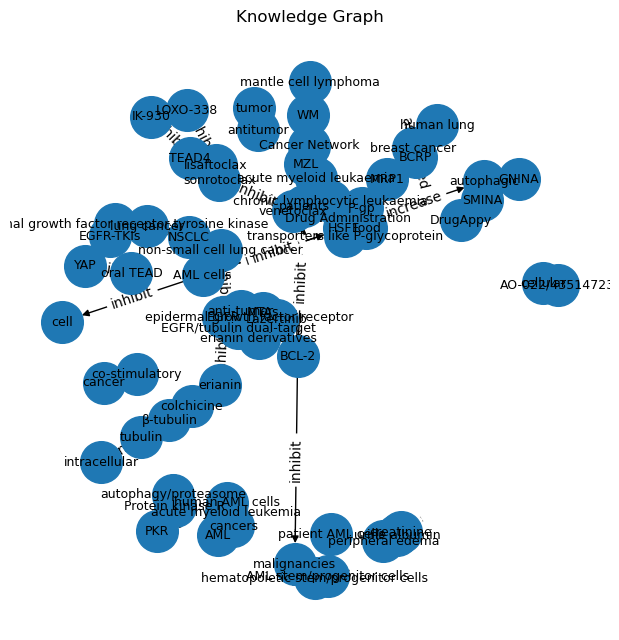

In [11]:
def extract_relations(text):
    doc = nlp(text)
    relations = []
    for sent in doc.sents:
        ents = sent.ents
        if len(ents)<2:
            continue
        sent_l = sent.text.lower()
        for t in TRIGGERS:
            if t in sent_l:
                for i in range(len(ents)):
                    for j in range(i+1, len(ents)):
                        relations.append({'sentence': sent.text.strip(),
                                         'e1': ents[i].text,
                                         'e2': ents[j].text,
                                         'trigger': t})
                        break
    return relations

query = 'cancer drug inhibitor'
docs = fetch_pubmed_abstracts(query, max_records=10)

triplets = []
for d in docs:
    txt = clean_text(d['abstract'])
    rels = extract_relations(txt)
    for r in rels:
        r.update({'pmid': d['pmid'], 'title': d['title']})
        triplets.append(r)

df = pd.DataFrame(triplets)
print('Triplets found', len(df))
display(df.head())
df.to_csv('pubmed_triplets.csv', index = False)

if not df.empty:
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['e1'], row['e2'], label = row['trigger'])
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, seed = 2)
    nx.draw(G, pos, with_labels=True, node_size=900, font_size=9)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G, 'label')) #font_color='red'))
    plt.title('Knowledge Graph')
    plt.show()

else:
    print('No relations detected')